# Классификация 128x128 + U-Net c бэкбоном

In [1]:
import os
from pathlib import Path

import json
from tqdm import tqdm
from sklearn.model_selection import train_test_split

import torch
import torchvision.transforms.v2 as transforms_v2
from torchvision.transforms.v2 import InterpolationMode

import pandas as pd
import matplotlib.pyplot as plt

# Import Utils.
from torch.utils.data import DataLoader
from src.utils.metrics import CombinedLoss, dice_coefficient, iou_score, pixel_accuracy

# Import Datasets.
from src.datasets.MoonSegmentBinaryDataset import MoonSegmentationDataset

# Import models.
from src.models.model_utilizer import load_net
from src.models.customUNet import customUNet
from src.models.customResNetUNet import customResNetUNet

from src.main import set_seed
from src.train import MetricsHistory

Настройки форматирования графиков общие.

In [2]:
user_fontsize = 16
mask_fontsize = 12

# legend_fontsize: 'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'
line_type = ['-', ':']
plot_mark = ['', 'o']

plot_xlabel = 'epoch'
split_list = ['train', 'validation']
plot_legend = split_list.copy()

tab10_colors = [
    '#1f77b4',  # tab:blue
    '#ff7f0e',  # tab:orange
    '#2ca02c',  # tab:green
    '#d62728',  # tab:red
    '#9467bd',  # tab:purple
    '#8c564b',  # tab:brown
    '#e377c2',  # tab:pink
    '#7f7f7f',  # tab:gray
    '#bcbd22',  # tab:olive
    '#17becf']  # tab:cyan

Пути к файлам конфигурации.

In [3]:
hyperparameters_dir = Path("./src/hyperparameters/")

config_path = hyperparameters_dir / "config.json"
assert config_path.exists(), f"Config not found: {config_path}"
with open(config_path, "r") as f:
    general_config = json.load(f)

checkpoints_dir = Path(general_config["checkpoints_dir"])
logs_dir = Path(general_config["logs_dir"])

Seed и device.

In [4]:
set_seed(general_config["seed"])
device = torch.device(general_config["device"].lower() if torch.cuda.is_available() else 'cpu')

## Часть 1. Классификатор 128×128

Настройки форматирования графиков.

In [5]:
user_figsize = (10, 6)

plot_titles = ["Losses", "Accuracy"]
plot_ylabels = [title.lower() for title in plot_titles]
METRIC_NUM = len(plot_titles)

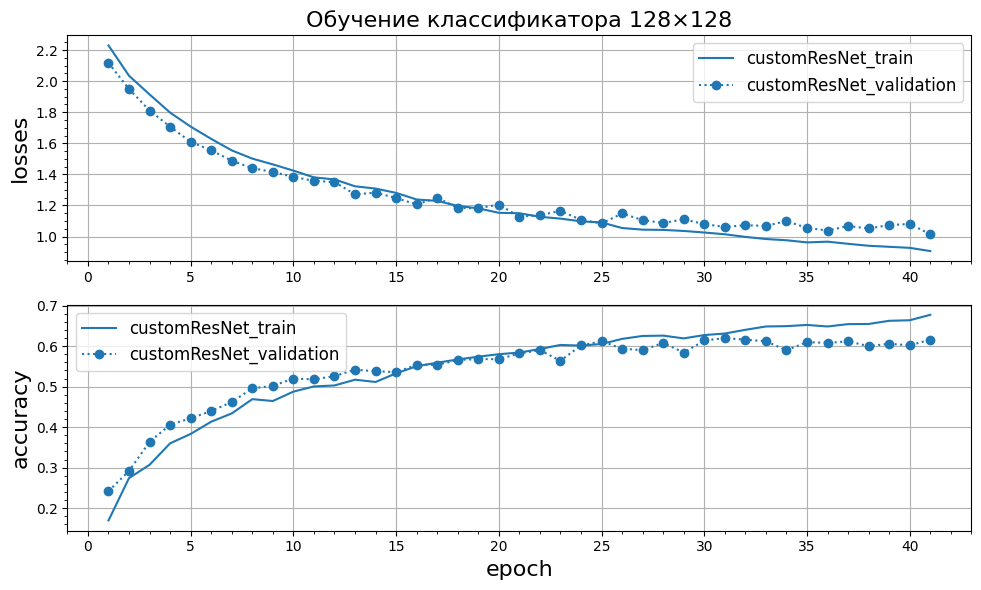

In [6]:
backbone_model_name = 'customResNet'

backbone_train_log_path = logs_dir / f"{backbone_model_name}.json"
assert backbone_train_log_path.exists(), f"Backbone log not found: {backbone_train_log_path}"
with open(backbone_train_log_path, "r") as f:
    backbone_train_log_full = json.load(f)
backbone_log_data_df = pd.DataFrame(backbone_train_log_full['train_log'])

plot_legend_local = []
fig, axs = plt.subplots(ncols=1, nrows=METRIC_NUM, figsize=user_figsize)
for k, ax in enumerate(axs):
    if k == 0:
        ax.set_title("Обучение классификатора 128×128", fontsize=user_fontsize)

    for m in range(len(split_list)):
        ax.plot(
            backbone_log_data_df.iloc[:,0], 
            backbone_log_data_df.iloc[:,3+METRIC_NUM*m+k],
            marker=plot_mark[m],
            linestyle=line_type[m],
            color=tab10_colors[0]
            )
        plot_legend_local.extend([backbone_model_name + '_' + tp for tp in plot_legend])
    ax.set_ylabel(plot_ylabels[k], fontsize=user_fontsize)
    ax.legend(plot_legend_local, fontsize='large')
    ax.grid()
    ax.minorticks_on()
ax.set_xlabel(plot_xlabel, fontsize=user_fontsize)

plt.tight_layout()
plt.savefig('readme_img/backbone.png', bbox_inches='tight')
plt.show()

## Части 2 и 3. Модели сегментации

In [7]:
from enum import IntEnum

# user-defined index.
class usid(IntEnum):
    customUNet = 0
    customResNetUNet = 1
    customResNetUNet_pretrained = 2

# Имена моделей.
model_names = [e.name for e in usid]

In [8]:
metadata_list = []
train_log_list = []
train_log_df_list = []
checkpoints_file_list = []

for name in model_names:
    train_log_path = logs_dir / f"{name}.json"
    assert train_log_path.exists(), f"Log not found: {train_log_path}"
    with open(train_log_path, "r") as f:
        train_log_full = json.load(f)
    metadata = train_log_full['metadata']
    
    checkpoints_file = checkpoints_dir / f"best_{name}.pth"
    assert checkpoints_file.exists(), f"Checkpoints not found: {checkpoints_file}"
    
    metadata_list.append(metadata)
    train_log_list.append(train_log_full['train_log'])
    train_log_df_list.append(pd.DataFrame(train_log_full['train_log']))
    checkpoints_file_list.append(checkpoints_file)

### moon-segmentation-binary
Аугментации.

In [9]:
metadata = metadata_list[usid.customUNet.value]
mdl_input_size = metadata['model']['input_size']

mean_norm = [0.485, 0.456, 0.406]
std_norm = [0.229, 0.224, 0.225]

val_augmentations = transforms_v2.Compose([
    transforms_v2.Resize(
        size=tuple(mdl_input_size[-2:]),
        interpolation=InterpolationMode.NEAREST,
        antialias=True
    ),
])

postprocessing = transforms_v2.Compose([
    transforms_v2.Normalize(mean=mean_norm, std=std_norm),
])

def denormalize(img_tensor):
    mean = torch.tensor(mean_norm).view(3, 1, 1)
    std = torch.tensor(std_norm).view(3, 1, 1)
    img = img_tensor * std + mean
    return img.clamp(0, 1)

Загрузка датасета.

In [10]:
data_path = Path(general_config.get("data_dir")) / metadata['dataset']['name']
data_path = data_path / 'images'

dataset_config_path = hyperparameters_dir / (metadata['dataset']['name'] + "-config.json")
assert dataset_config_path.exists(), f"Config not found: {dataset_config_path}"
with open(dataset_config_path, "r") as f:
    dataset_config = json.load(f)

img_prefix = dataset_config['img_prefix']
mask_prefix = dataset_config['mask_prefix']
img_folder = img_prefix + '/'
all_images = [img_no_ext.replace(img_prefix, '') for img_no_ext in
    [img.replace('.png', '') for img in sorted(os.listdir(data_path / img_folder)) if img.endswith('.png')]
]

train_images, val_images = train_test_split(
    all_images,
    test_size=0.2,
    random_state = general_config.get('seed'))

val_loader = DataLoader(
    MoonSegmentationDataset(
        data_path = data_path,
        samples = val_images,
        img_prefix = img_prefix,
        mask_prefix = mask_prefix,
        geometric_augmentations = val_augmentations,
        photometric_augmentations = None,
        postprocessing = postprocessing
    ),
    batch_size=metadata["batch_size"],
    shuffle=False,
    num_workers=metadata["workers"],
    pin_memory=True)

print(f"Valid. size: {len(val_loader.dataset)}")

Valid. size: 200


Загрузка моделей сементации.

In [11]:
model_list = []
epoch_list = []
 
for idx, name in enumerate(model_names):
    metadata = metadata_list[idx]
    
    if name == 'customUNet':
        model = customUNet(
            in_channels = mdl_input_size[0],
            out_channels = 1,
            features = metadata['model']['feature_list']
            )
    
    elif 'customResNetUNet' in name:
        if 'pretrained' in name:
            backbone_pretrained_flag = True
            backbone_checkpoints_file = Path(general_config['backbone_model_dir']) / \
                metadata['model']['backbone_model_name']
        else:
            backbone_pretrained_flag = False
            backbone_checkpoints_file = None
        
        model = customResNetUNet(
            in_channels = mdl_input_size[0],
            out_channels = 1,
            features = metadata['model']['feature_list'],
            backbone_layers_config = metadata['model']['backbone_layers_num']*[metadata['model']['backbone_block_size']],
            backbone_layer0_channels = metadata['model']['feature_list'][0],
            backbone_pretrained = backbone_pretrained_flag,
            backbone_checkpoints_file = backbone_checkpoints_file,
            device = device
            )

    model, epoch, _, _ = load_net(
                net = model,
                checkpoints_file = checkpoints_file_list[idx],
                device = device
        )

    model.eval()
    
    model_list.append(model)
    epoch_list.append(epoch)


Encoder features by level: [18, 36, 72, 144]
Restoring checkpoint:  checkpoints\best_customUNet.pth
Encoder features by level: [18, 36, 72, 144]
Restoring checkpoint:  checkpoints\best_customResNetUNet.pth
Restoring checkpoint:  checkpoints\backbones\best_customResNet.pth
Unexpected keys: ['fc.weight', 'fc.bias']
Encoder features by level: [18, 36, 72, 144]
Restoring checkpoint:  checkpoints\best_customResNetUNet_pretrained.pth


Тестируем правильно ли загрузились модели.

In [12]:
loss_func = CombinedLoss(bce_weight=0.5, dice_weight=0.5).to(device)

metrics = MetricsHistory()
metrics.initialize_metrics(
    ['loss', 'dice', 'iou', 'accuracy'],
    ['val']
    )
for idx, model in enumerate(model_list):
    with torch.no_grad():
        for data_tuple in tqdm(val_loader, desc="Val"):
            
            inputs, masks = data_tuple[0].to(device), data_tuple[1].to(device)
            
            outputs = model(inputs)
                    
            #print('pred', np.round([np.mean(np.array(outputs)), np.min(np.array(outputs)), np.max(np.array(outputs))], 4))
            #print('mask', np.round([np.mean(np.array(masks)), np.min(np.array(masks)), np.max(np.array(masks))], 4))
            
            loss = loss_func(outputs, masks)

            metrics.update_metrics(
                split = "val",
                batch_size = inputs.size(0),
                loss = loss.item(),
                dice = dice_coefficient(outputs.detach(), masks.detach()),
                iou = iou_score(outputs.detach(), masks.detach()),
                accuracy = pixel_accuracy(outputs.detach(), masks.detach()))
            metrics.log_epoch_history(['val'])
            
    print(model_names[idx])
    
    metrics.print_metrics(['val'])
    
    print(f"Loaded loss: {train_log_list[idx][epoch_list[idx]-1]['val_loss']:.4f}, "
        f"dice: {train_log_list[idx][epoch_list[idx]-1]['val_dice']:.4f}, "
        f"iou: {train_log_list[idx][epoch_list[idx]-1]['val_iou']:.4f}, "
        f"accuracy: {train_log_list[idx][epoch_list[idx]-1]['val_accuracy']:.4f}")

    metrics.reset_metrics()

Val: 100%|██████████| 2/2 [00:03<00:00,  1.71s/it]


customUNet
Valid. loss: 0.3276, dice: 0.6226, iou: 0.4527, accuracy: 0.9201
Loaded loss: 0.3276, dice: 0.6226, iou: 0.4527, accuracy: 0.9201


Val: 100%|██████████| 2/2 [00:03<00:00,  1.67s/it]


customResNetUNet
Valid. loss: 0.3756, dice: 0.5680, iou: 0.3970, accuracy: 0.9008
Loaded loss: 0.3756, dice: 0.5680, iou: 0.3970, accuracy: 0.9008


Val: 100%|██████████| 2/2 [00:03<00:00,  1.70s/it]

customResNetUNet_pretrained
Valid. loss: 0.3666, dice: 0.5828, iou: 0.4117, accuracy: 0.9091
Loaded loss: 0.3666, dice: 0.5828, iou: 0.4117, accuracy: 0.9091


In [13]:
def visualize_predictions(
    name,
    model,
    dataloader,
    threshold,
    color,
    alpha,
    device,
    num_samples
    ):
    
    images, masks = next(iter(dataloader))
    
    with torch.no_grad():
        logits = model(images.to(device))
        outputs = torch.sigmoid(logits)
        predictions = (outputs.detach() > threshold).float()
    
    images = images.cpu()
    masks = masks.cpu()
    predictions = predictions.cpu()
    
    _, axes = plt.subplots(num_samples, 4, figsize=(10, 3.2*num_samples), constrained_layout=True)
    plt.suptitle(name, fontsize=user_fontsize, fontweight='bold', y=0.965)
    
    for i in range(num_samples):
        img = denormalize(images[i]).permute(1, 2, 0).numpy()
        mask_true = masks[i, :].squeeze(0).numpy() 
        mask_pred = predictions[i, :].squeeze(0).numpy()
        
        dice = dice_coefficient(logits[i].cpu(), masks[i])
        iou = iou_score(logits[i].cpu(), masks[i])
        
        axes[i, 0].imshow(img)
        axes[i, 0].set_title('Исходное изображение', fontsize=mask_fontsize)
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(mask_true, cmap='gray')
        axes[i, 1].set_title('Истинная маска', fontsize=mask_fontsize)
        axes[i, 1].axis('off')
        
        axes[i, 2].imshow(mask_pred, cmap='gray')
        axes[i, 2].set_title('Предсказание', fontsize=mask_fontsize)
        axes[i, 2].axis('off')
        
        overlay_mask = img.copy()
        overlay_mask[mask_pred > threshold] = color
        overlay = (1 - alpha) * img + alpha * overlay_mask
        
        axes[i, 3].imshow(overlay)
        axes[i, 3].set_title('Наложение', fontsize=mask_fontsize)
        axes[i, 3].annotate(
            f'Dice: {dice:.4f} | IoU: {iou:.4f}',
            xy=(1.0, 0.5),
            xytext=(1.1, 0.55),
            xycoords='axes fraction',
            textcoords='axes fraction',
            va='center',
            ha='center',
            fontsize=mask_fontsize,
            fontweight='bold',
            rotation=90
        )
        axes[i, 3].axis('off')   
    
    plt.tight_layout()
    plt.savefig(f"readme_img/samples_{name}.png", bbox_inches='tight')
    plt.show()

C:\Users\rgorbunov\AppData\Local\Temp\ipykernel_65532\2585411440.py:66: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


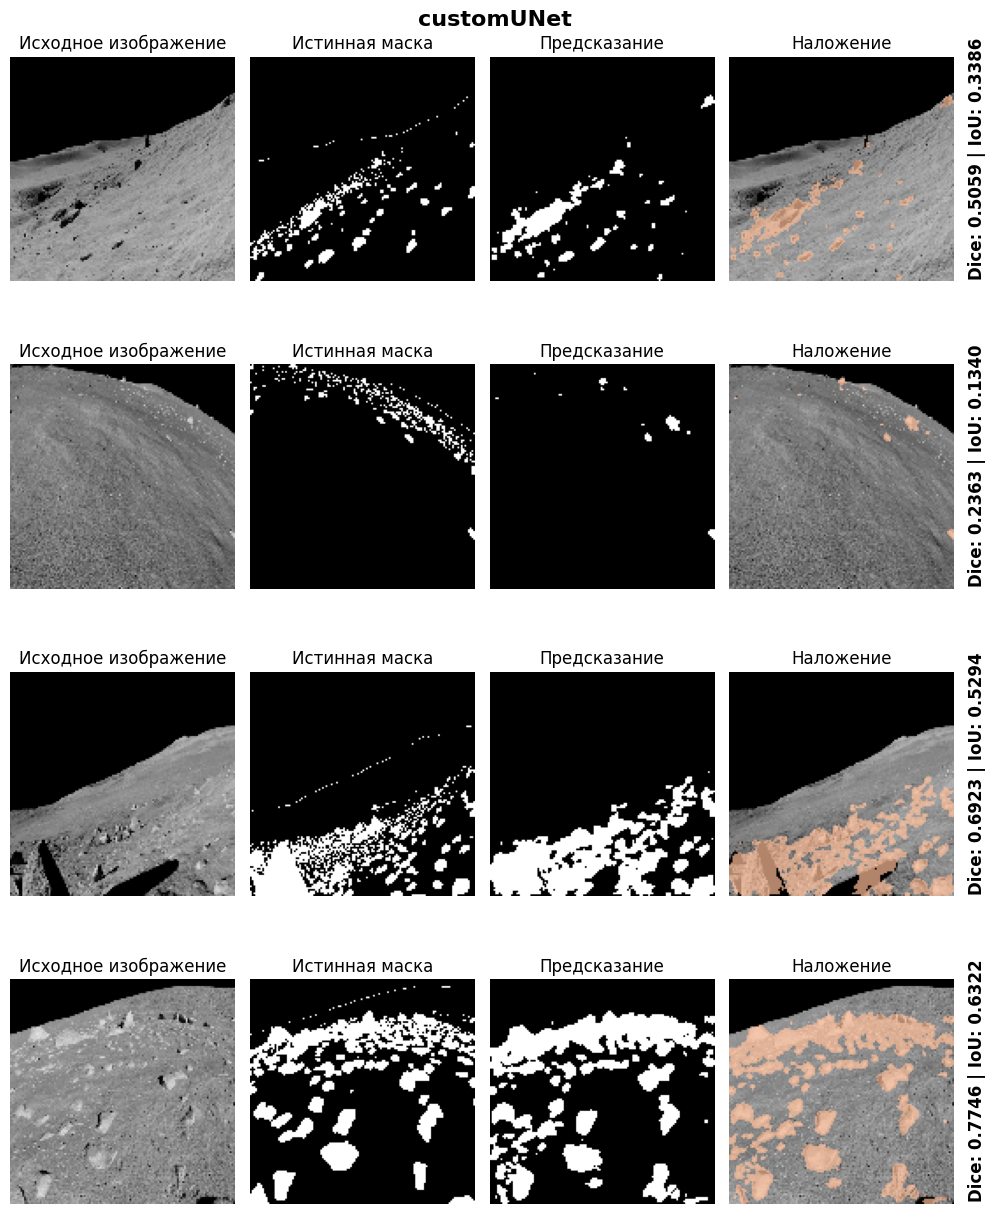

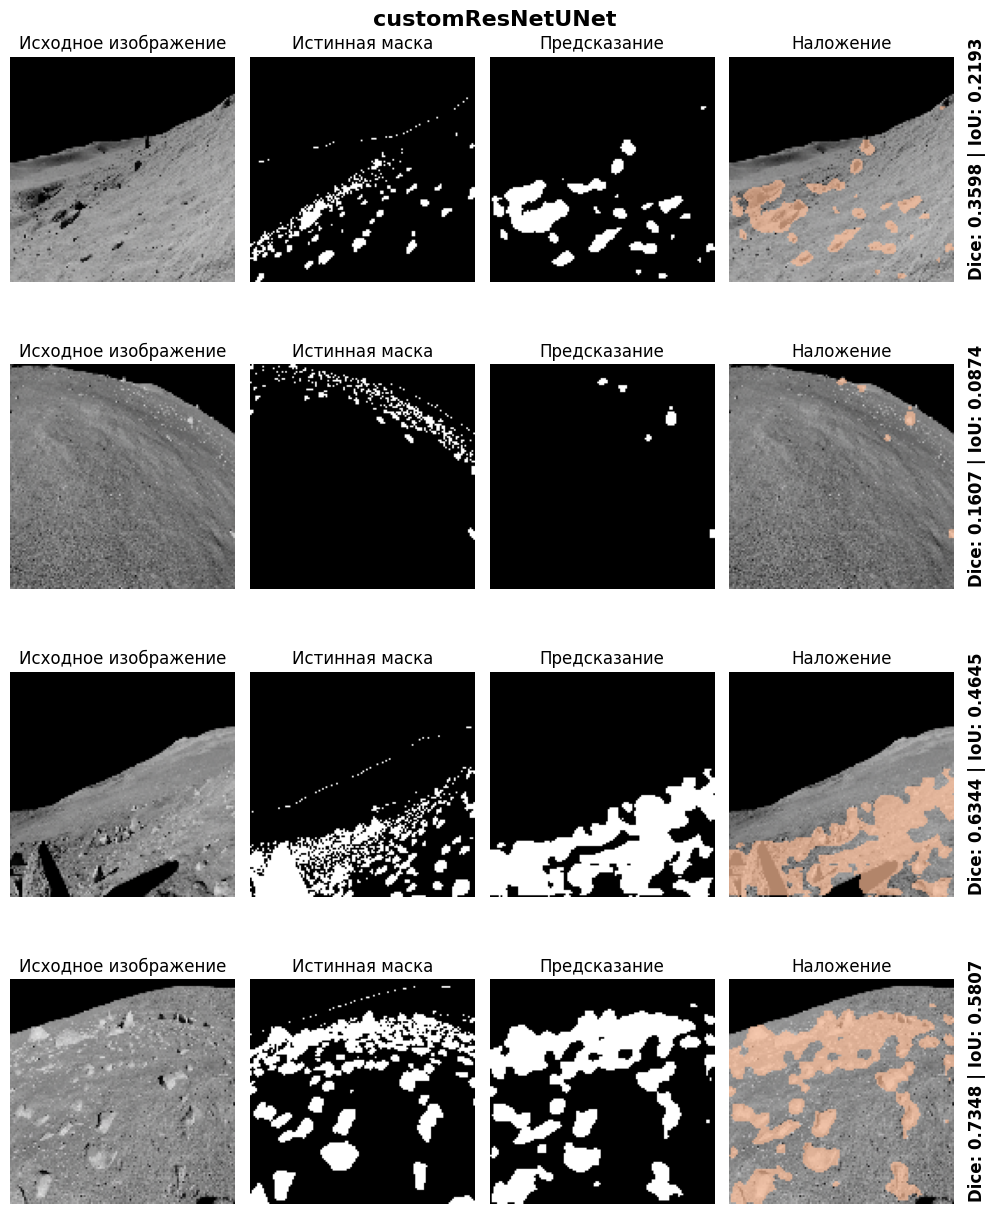

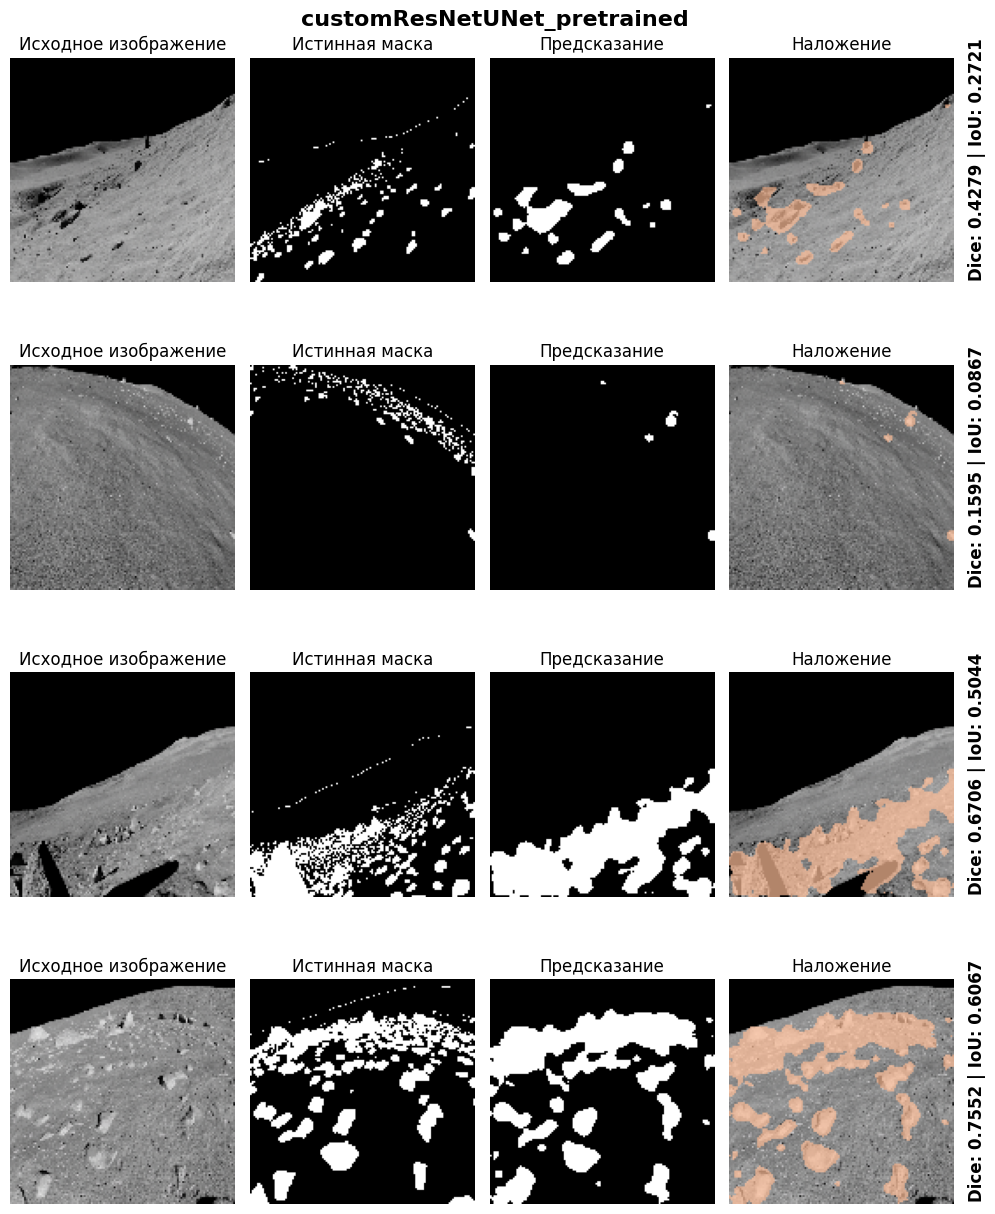

In [14]:
color_Pantone = [255.0/255.0, 190.0/255.0, 152.0/255.0]
color_Mousse = [164.0/255.0, 120.0/255.0, 100.0/255.0]

for name, model in zip(model_names, model_list):
    visualize_predictions(
        name = name,
        model = model,
        dataloader = val_loader,
        threshold = 0.5,
        color = color_Pantone,
        alpha = 0.7,
        device = device,
        num_samples = 4
        )

Размер батча изображений: torch.Size([100, 3, 128, 128])
Размер батча масок: torch.Size([100, 1, 128, 128])


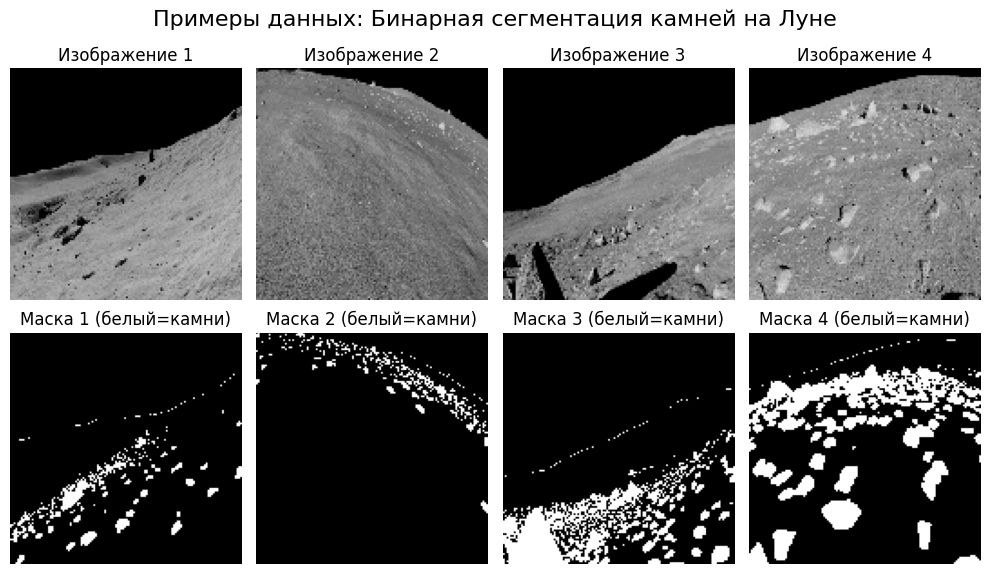

In [15]:
images, masks = next(iter(val_loader))

print(f"Размер батча изображений: {images.shape}")
print(f"Размер батча масок: {masks.shape}")

fig, axes = plt.subplots(2, 4, figsize=(10, 6))

for i in range(min(4, len(images))):
    img = denormalize(images[i]).permute(1, 2, 0).numpy()
    mask = masks[i].permute(1, 2, 0).numpy()
    
    axes[0, i].imshow(img)
    axes[0, i].set_title(f"Изображение {i+1}")
    axes[0, i].axis('off')
    
    axes[1, i].imshow(mask, cmap='gray')
    axes[1, i].set_title(f"Маска {i+1} (белый=камни)")
    axes[1, i].axis('off')

plt.suptitle("Примеры данных: Бинарная сегментация камней на Луне", fontsize=16)
plt.tight_layout()
plt.show()

Загрузка логов обучения.

In [16]:
user_figsize = (10, 18)

plot_titles = ["Losses", "dice", "IoU", "Accuracy"]
plot_ylabels = [title.lower() for title in plot_titles]
METRIC_NUM = len(plot_titles)
line_type *= len(model_names)
plot_mark *= len(model_names)

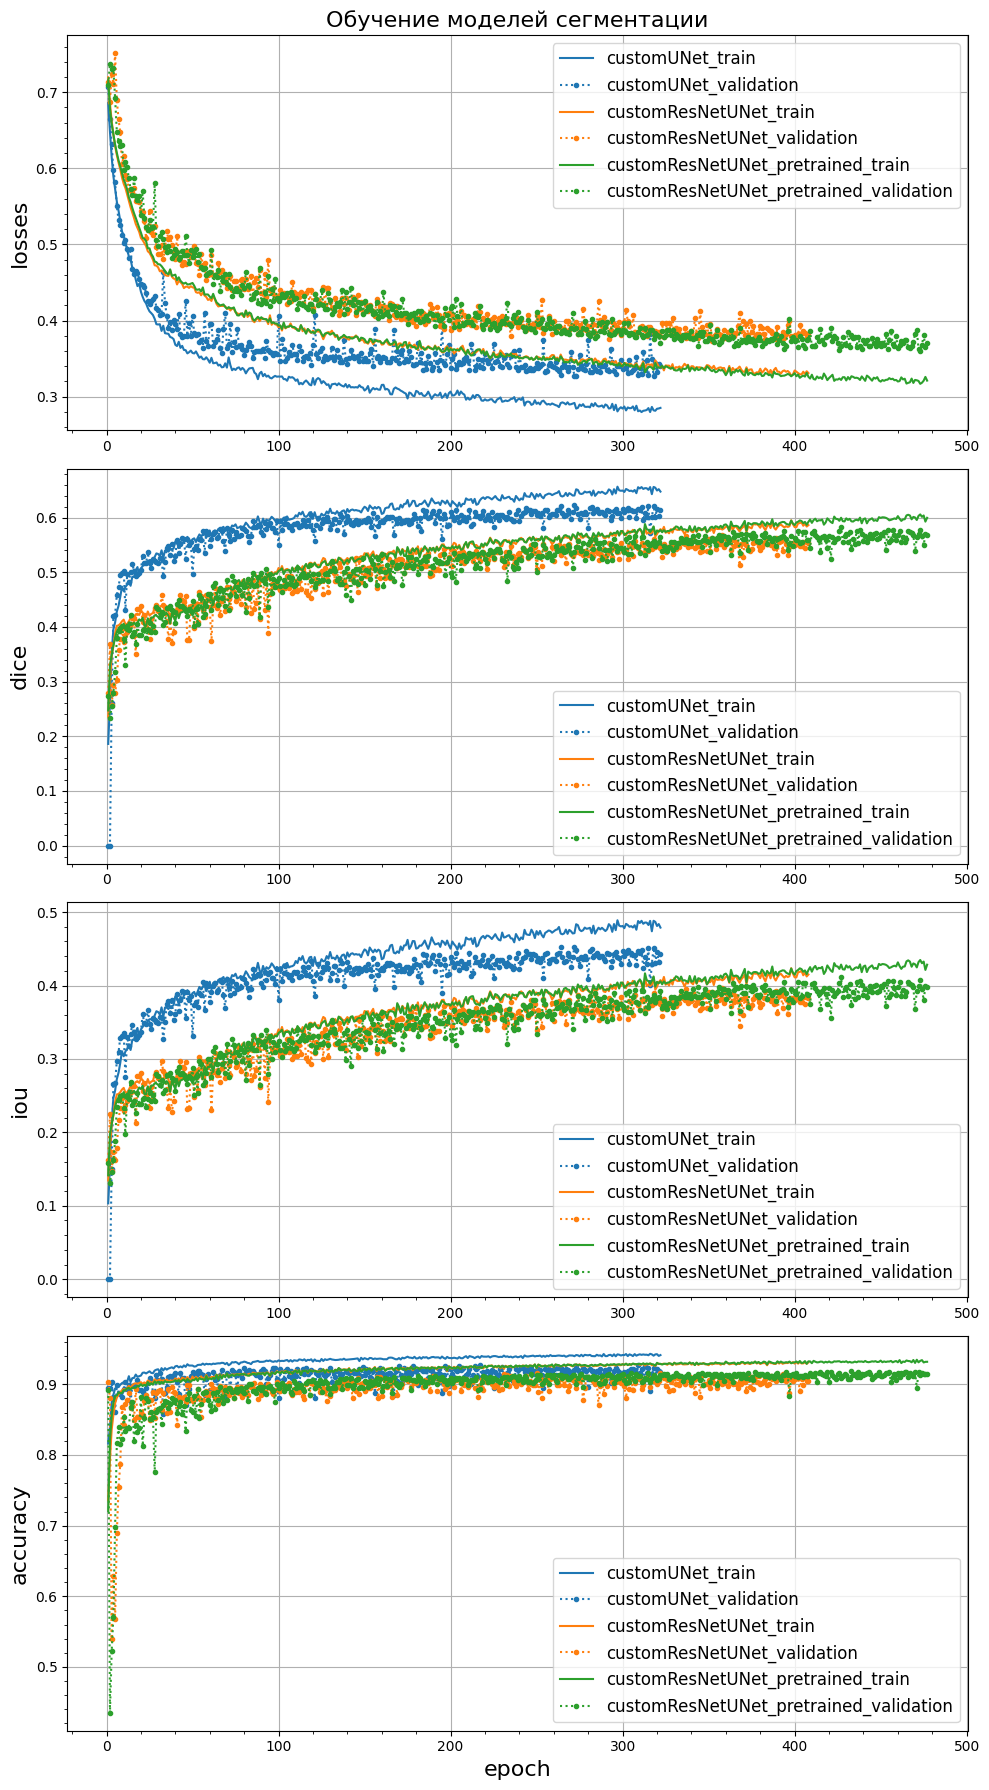

In [20]:
plot_idx = [
    usid.customUNet.value,
    usid.customResNetUNet.value,
    usid.customResNetUNet_pretrained.value
]

plot_legend_local = []
fig, axs = plt.subplots(ncols=1, nrows=METRIC_NUM, figsize=user_figsize)
for k, ax in enumerate(axs):
    if k == 0:
        ax.set_title("Обучение моделей сегментации", fontsize=user_fontsize)
    for idx in plot_idx:
        for m in range(len(split_list)):
            ax.plot(
                train_log_df_list[idx].iloc[:,0], 
                train_log_df_list[idx].iloc[:,3+METRIC_NUM*m+k],
                marker=plot_mark[m],
                markersize=3,
                linestyle=line_type[m],
                color=tab10_colors[idx]
                )
        plot_legend_local.extend([model_names[idx] + '_' + tp for tp in plot_legend])
    ax.set_ylabel(plot_ylabels[k], fontsize=user_fontsize)
    ax.legend(plot_legend_local, fontsize='large')
    ax.grid()
    ax.minorticks_on()
ax.set_xlabel(plot_xlabel, fontsize=user_fontsize)   

plt.tight_layout()
plt.savefig('readme_img/UNet.png', bbox_inches='tight')
plt.show()